In [2]:
import random
import string

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pandas as pd
import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Load plot settings

import sys
sys.path.append("../../spectral_distortions_perturbations/notebooks/")

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import torch
import gpytorch
import pyro
from pyro.infer.autoguide import AutoLaplaceApproximation, AutoIAFNormal, AutoMultivariateNormal, AutoNormalizingFlow, AutoDiagonalNormal, AutoDelta, init_to_mean
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

In [5]:
sys.path.append("../../unresolved-subhalos-non-parametric/")
from NPTFitG.pdf_sampler import PDFSampler

In [6]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [7]:
import sys
sys.path.append("../")
from models.psf import KingPSF
from models.scd import dnds
from simulations.simulate_ps import SimulateMap
from models.regression import NPRegression

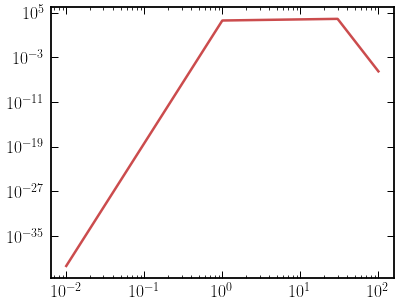

In [8]:
theta = torch.tensor([4000., 20., 1.8, -20., 30., 1.])
s_ary = torch.logspace(-2, 2, 1000)
dnds_ary = dnds(s_ary, theta)
# dnds_ary = dnds_ary
plt.plot(s_ary, s_ary ** 2 * dnds_ary.detach().numpy())
plt.xscale("log")
plt.yscale("log")

In [9]:
psf_sigma_deg = 1e-4
psf_r = lambda r: KingPSF.psf_gauss_r(r, psf_sigma_deg)

In [10]:
nside = 128

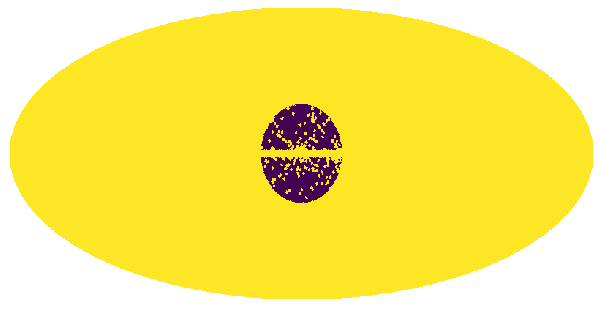

In [11]:
import sys
sys.path.append("../")

from utils import create_mask as cm

# ps_mask = hp.ud_grade(np.load("../data/fermi_data/fermidata_pscmask.npy") > 0, nside_out=nside)
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, 
                          custom_mask=ps_mask
                              )

mask_no_ps = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, 
#                           custom_mask=ps_mask
                              )

hp.mollview(mask,title='',cbar=False,min=0,max=1)

In [12]:
temp_bub = hp.ud_grade(np.load('../data/fermi_data/template_bub.npy'), nside_out=nside, power=-2)
temp_iso = hp.ud_grade(np.load('../data/fermi_data/template_iso.npy'), nside_out=nside, power=-2)
temp_dif = hp.ud_grade(np.load('../data/fermi_data/template_dif.npy'), nside_out=nside, power=-2)
temp_psc = hp.ud_grade(np.load('../data/fermi_data/template_psc.npy'), nside_out=nside, power=-2)
temp_gce = hp.ud_grade(np.load('../data/fermi_data/template_gce.npy'), nside_out=nside, power=-2)

fermi_counts = np.load('../data/fermi_data/fermidata_counts.npy')

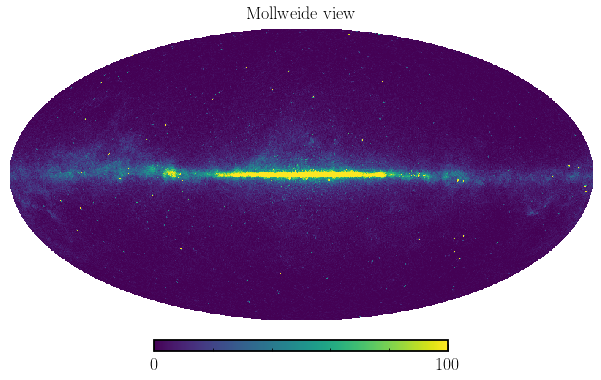

In [13]:
sim = SimulateMap([temp_bub, temp_iso, temp_dif, temp_psc, temp_gce], [0.2, 0.1, 13., 0.5, 0.], [s_ary], [dnds_ary.detach().numpy()], [temp_gce / np.mean(temp_gce)], psf_r, nside=nside)
data = sim.create_map()
hp.mollview(data, max=100)

In [14]:
np.sum(sim.ps_map[~mask]) / np.sum(data[~mask])

0.05473773348956743

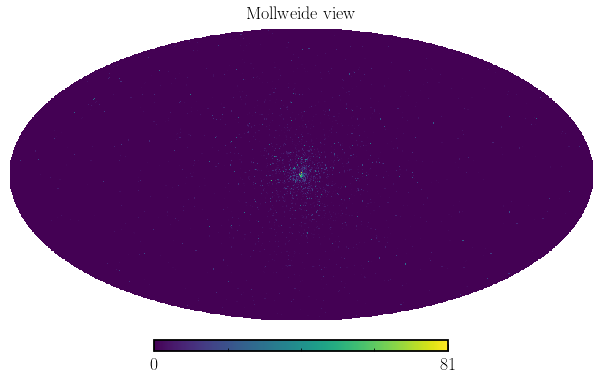

In [15]:
hp.mollview(sim.ps_map)

In [16]:
np.max(fermi_counts[~mask])

82.0

In [17]:
np.max(data[~mask])

91

In [17]:
from utils.distributions import LogUniform

In [949]:
npr = NPRegression(poiss_temps=[temp_iso, temp_bub, temp_psc, temp_dif, temp_gce],
            poiss_priors=[dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
#                           dist.Normal(torch.tensor(13.), torch.tensor(3.)),
                          dist.Uniform(torch.tensor(11.), torch.tensor(20.)),
                          dist.Uniform(torch.tensor(-8.), torch.tensor(-1.))],
            poiss_log_priors=torch.tensor([0., 0., 0., 0., 1.]),
            ps_temps=[temp_gce / np.mean(temp_gce)],
            ps_priors=[[dist.Uniform(torch.tensor(-8.), torch.tensor(-1.)), 
                        dist.Uniform(torch.tensor(11.0), torch.tensor(20.0)), 
                        dist.Uniform(torch.tensor(0.1), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(-10.0), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(11.), torch.tensor(100.)), 
                        dist.Uniform(torch.tensor(-3.), torch.tensor(1.))]],
            ps_log_priors=torch.tensor([[1., 0., 0., 0., 0., 1.]]),
            data = torch.tensor(data, dtype=torch.float64),
            labels_poiss=["iso", "bub", "psc", "dif", "gce"],
            labels_ps=["gce"],
            mask=mask,
            subsample_size=600)
#             subsample_size=len(data[~mask]))

../models/regression.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)


In [950]:
pixel_frac = hp.nside2pixarea(nside, degrees=False) / (4 * np.pi)
pixel_frac

np.log10(4000 * pixel_frac)

-1.6915411940153993

In [964]:
pyro.clear_param_store()

In [965]:
from pyro.distributions.transforms import iterated, block_autoregressive
from functools import partial

guide = AutoIAFNormal(npr.model,hidden_dim=3, num_transforms=16)
guide = npr.guide
# guide = AutoMultivariateNormal(npr.model, init_loc_fn=init_to_mean)

In [966]:
pyro.enable_validation(True)

In [967]:
elbo = TraceGraph_ELBO()
optimizer = optim.Adam({"lr": 1e-2})

In [968]:
len(data[~mask])

6839

In [974]:
num_iterations = 4000

svi = SVI(npr.model,
          guide,
          optimizer,
          loss=elbo)

for j in range(num_iterations):
    loss = svi.step()    
    if j % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 0.0962
[iteration 0051] loss: 0.0966
[iteration 0101] loss: 0.0952
[iteration 0151] loss: 0.0935
[iteration 0201] loss: 0.0974
[iteration 0251] loss: 0.0960
[iteration 0301] loss: 0.0960
[iteration 0351] loss: 0.0964
[iteration 0401] loss: 0.0955
[iteration 0451] loss: 0.0957
[iteration 0501] loss: 0.0952
[iteration 0551] loss: 0.0956
[iteration 0601] loss: 0.0976
[iteration 0651] loss: 0.0951
[iteration 0701] loss: 0.0961
[iteration 0751] loss: 0.0969
[iteration 0801] loss: 0.0952
[iteration 0851] loss: 0.0943
[iteration 0901] loss: 0.0972
[iteration 0951] loss: 0.0970
[iteration 1001] loss: 0.0967
[iteration 1051] loss: 0.0984
[iteration 1101] loss: 0.0942
[iteration 1151] loss: 0.0960
[iteration 1201] loss: 0.0974
[iteration 1251] loss: 0.0955
[iteration 1301] loss: 0.0985
[iteration 1351] loss: 0.0991
[iteration 1401] loss: 0.0941
[iteration 1451] loss: 0.0953
[iteration 1501] loss: 0.0953
[iteration 1551] loss: 0.0934
[iteration 1601] loss: 0.0966
[iteration

In [970]:
npr.guide()

{'iso': tensor(0.2676, grad_fn=<ExpandBackward>),
 'bub': tensor(0.1721, grad_fn=<ExpandBackward>),
 'psc': tensor(1.7624, grad_fn=<ExpandBackward>),
 'dif': tensor(13.1789, grad_fn=<ExpandBackward>),
 'gce': tensor(-5.7972, grad_fn=<ExpandBackward>),
 'A_ps_gce': tensor(-2.9292, grad_fn=<ExpandBackward>),
 'n_1_gce': tensor(15.2971, grad_fn=<ExpandBackward>),
 'n_2_gce': tensor(1.0916, grad_fn=<ExpandBackward>),
 'n_3_gce': tensor(-4.0127, grad_fn=<ExpandBackward>),
 'Sb_1_gce': tensor(25.5007, grad_fn=<ExpandBackward>),
 'Sb_2_gce': tensor(0.4245, grad_fn=<ExpandBackward>)}

In [971]:
guide()

{'iso': tensor(0.2326, grad_fn=<ExpandBackward>),
 'bub': tensor(0.1767, grad_fn=<ExpandBackward>),
 'psc': tensor(1.2136, grad_fn=<ExpandBackward>),
 'dif': tensor(13.0597, grad_fn=<ExpandBackward>),
 'gce': tensor(-6.9110, grad_fn=<ExpandBackward>),
 'A_ps_gce': tensor(-2.8682, grad_fn=<ExpandBackward>),
 'n_1_gce': tensor(14.4341, grad_fn=<ExpandBackward>),
 'n_2_gce': tensor(0.6345, grad_fn=<ExpandBackward>),
 'n_3_gce': tensor(0.7981, grad_fn=<ExpandBackward>),
 'Sb_1_gce': tensor(21.8733, grad_fn=<ExpandBackward>),
 'Sb_2_gce': tensor(0.1855, grad_fn=<ExpandBackward>)}

In [975]:
num_samples = 1500

predictive = Predictive(npr.model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in (predictive().items())
               if k != "obs"}

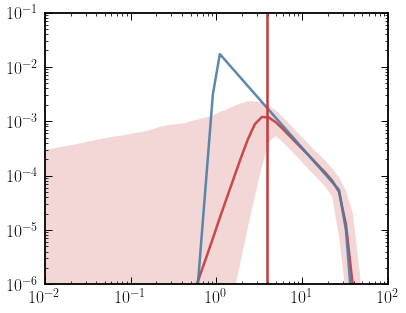

In [976]:
from models.scd import dnds
samplez = np.transpose([svi_samples[key] for key in svi_samples.keys()])
samplez[:,5] = 10 ** samplez[:,5]
samplez[:,-1] = 10 ** samplez[:,-1]
s_ary = np.logspace(-2, 2)
dnds_ary = [dnds(torch.tensor(s_ary), torch.tensor(s)).detach().numpy() for s in samplez[:,5:]]
plt.plot(s_ary, np.median(dnds_ary, axis=0))
plt.fill_between(s_ary, np.percentile(dnds_ary, [5.], axis=0)[0], np.percentile(dnds_ary, [95.], axis=0)[0], alpha=0.2)
theta_sim = torch.tensor([4000., 20., 1.8, -20., 30., 1.])
plt.plot(s_ary, dnds(torch.tensor(s_ary), theta_sim).detach().numpy() / len(data))
plt.xlim(1e-2, 1e2)
plt.ylim(1e-6, 1e-1)
plt.axvline(np.sqrt(np.mean(data[~mask])))

plt.xscale("log")
plt.yscale("log")

In [977]:
from getdist import plots, MCSamples
import getdist

names = np.arange(len(svi_samples.keys())).astype(str)  #['$' + blah + '$' for blah in svi_samples.keys()]
labels = names
samples = np.transpose([svi_samples[key] for key in svi_samples.keys()])


In [978]:
samples = MCSamples(samples=samples, names=names, labels=labels)
g = plots.get_subplot_plotter()

Removed no burn in


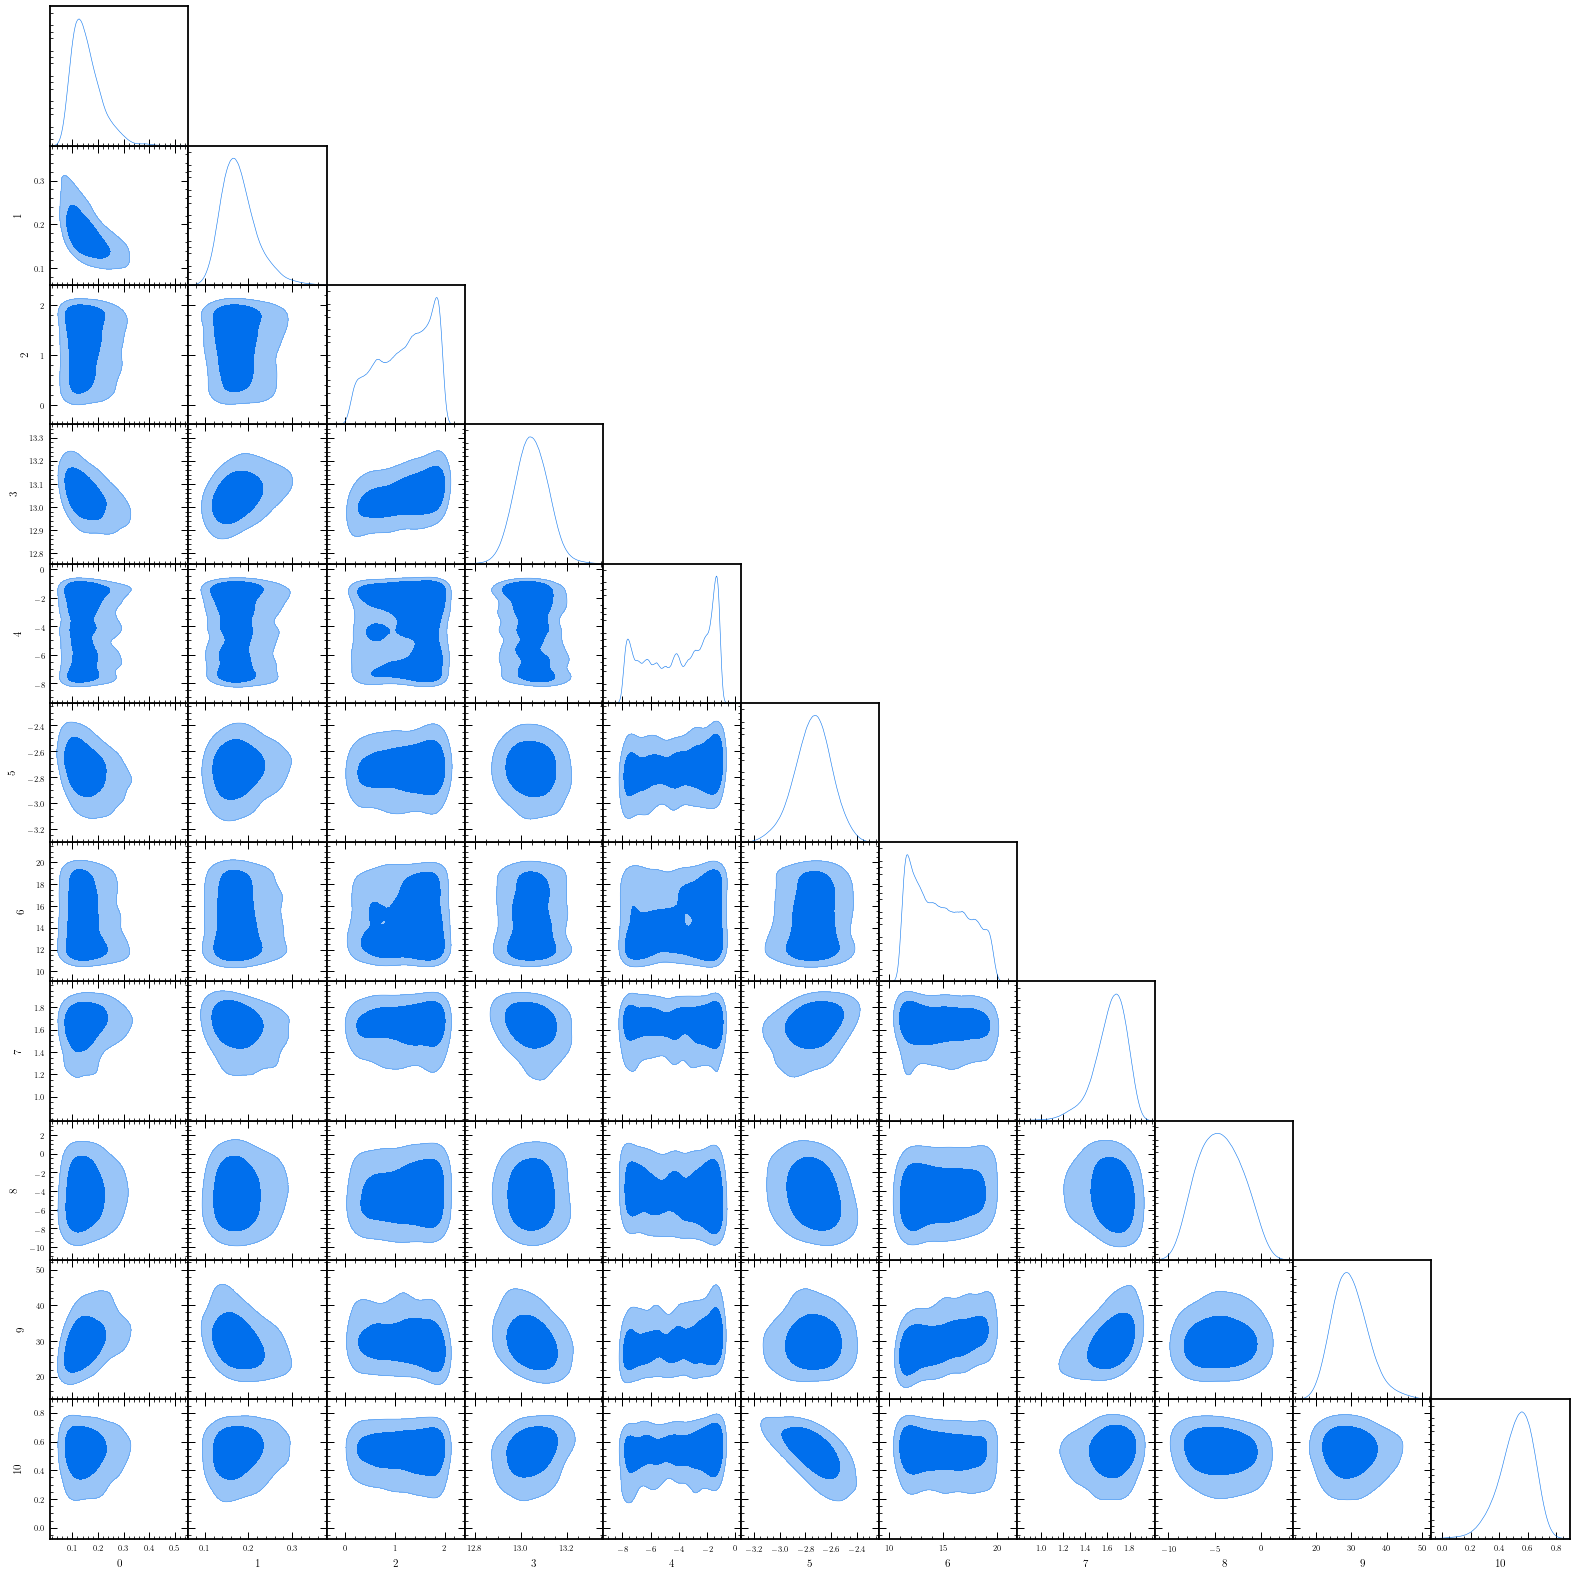

In [979]:
g.triangle_plot([samples], filled=True);


In [980]:
np.log10(4000 * pixel_frac)

-1.6915411940153993

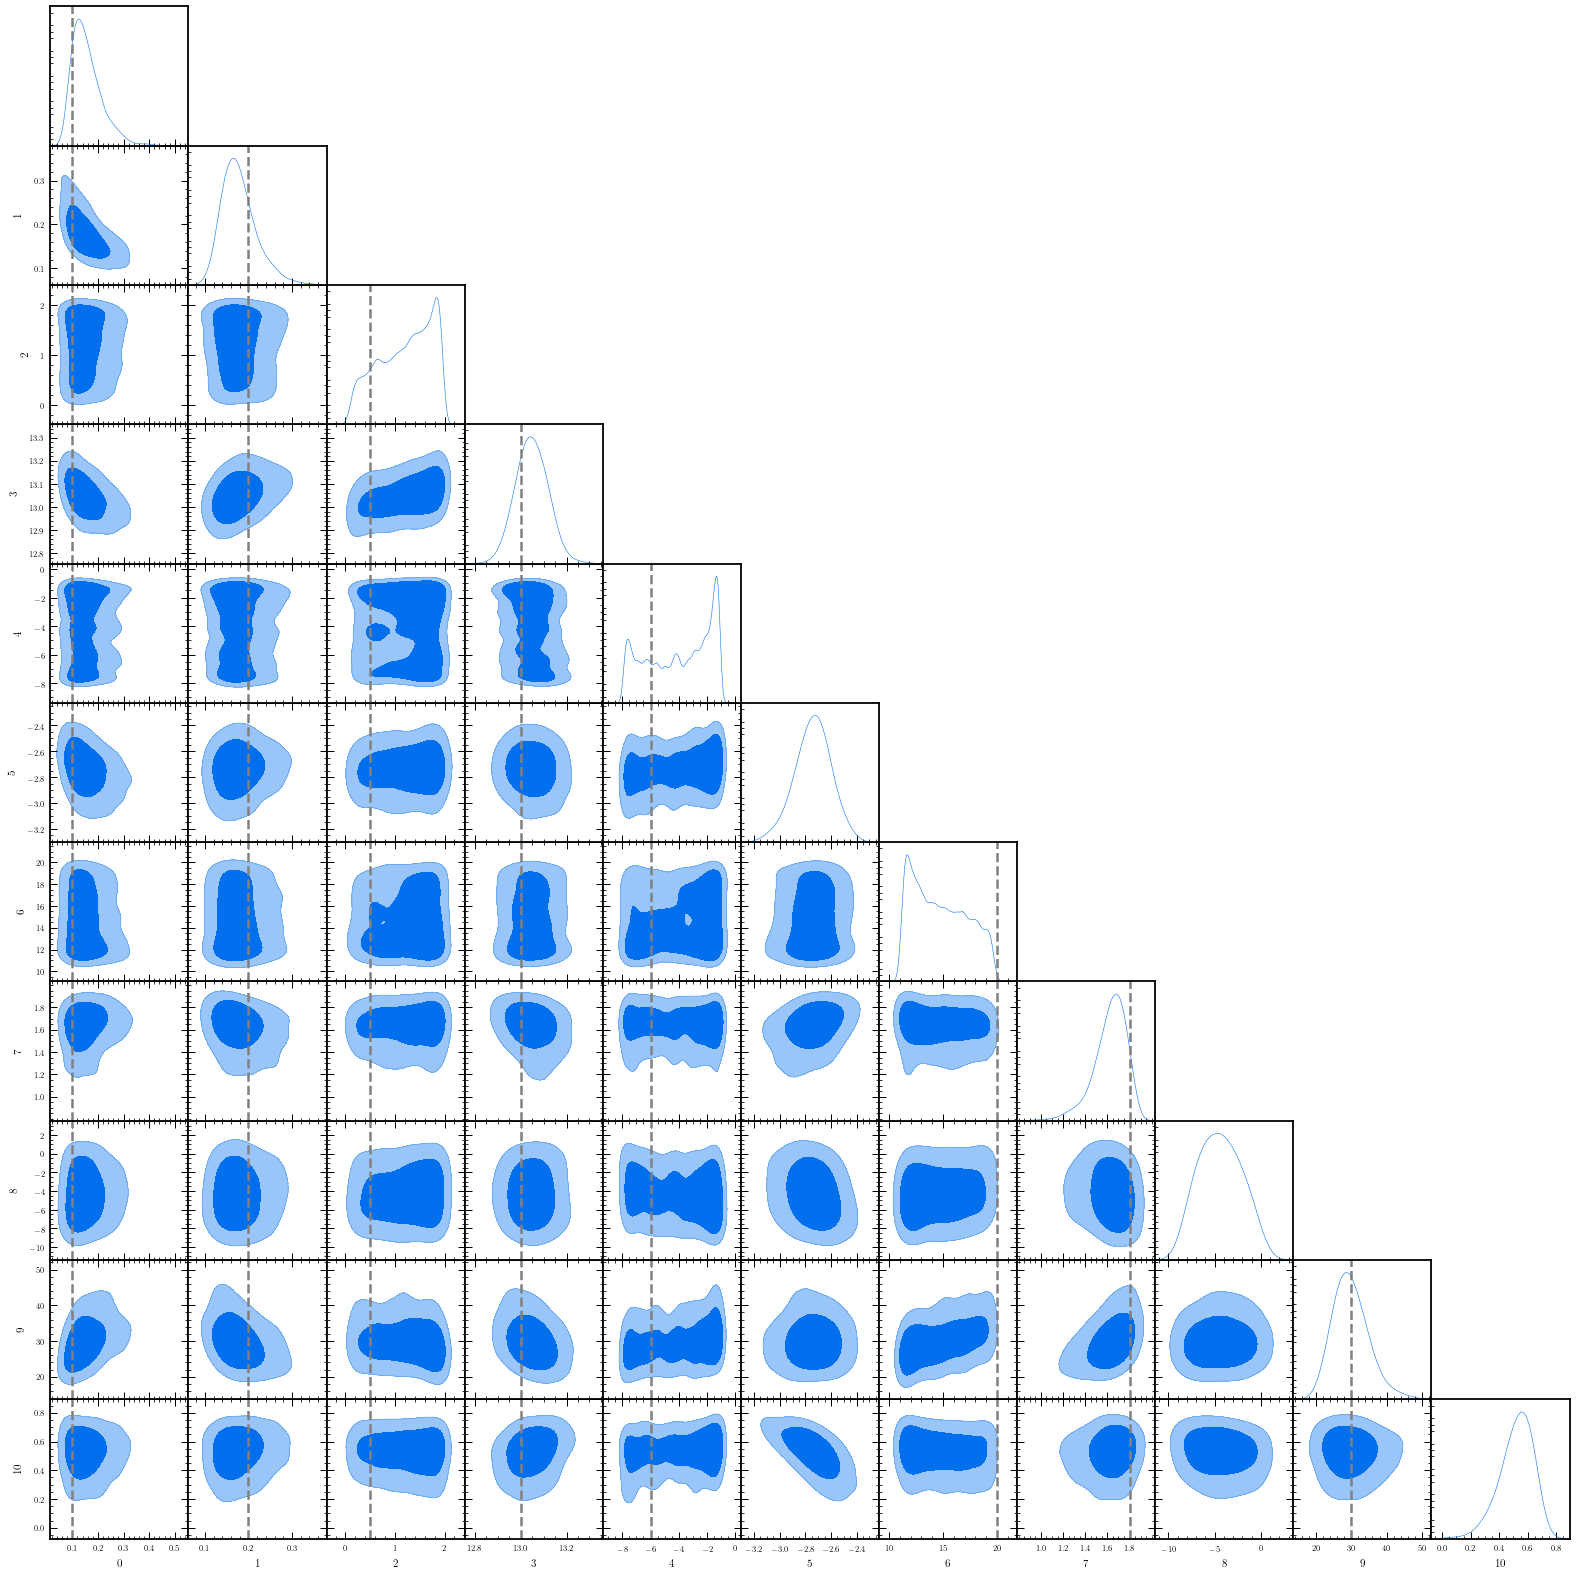

In [981]:
import IPython
truths = [0.1, 0.2, 0.5, 13., -6., np.log10(4000 * pixel_frac), 20., 1.8, -20., 30., 1.]
for t in range(11):
    for ax in (g.subplots[t:,t]):
        ax.axvline(truths[t], color='gray', ls='--')
IPython.display.display(g.fig)

In [2169]:
np.trapz(s_ary * np.percentile(dnds_ary, 95, axis=0), s_ary) * np.sum(temp_gce[~mask]) / np.sum(temp_gce) * len(temp_gce)

7029.04643467702

In [2163]:
np.sum(sim.ps_map[~mask])

5390.0

In [2626]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [2627]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: iso
      mean       std        5%       25%       50%       75%      95%
0  0.19158  0.037118  0.137947  0.165175  0.185574  0.214293  0.25629 

Site: bub
       mean       std        5%       25%       50%       75%       95%
0  0.192777  0.024381  0.157648  0.176437  0.189775  0.207519  0.238011 

Site: psc
       mean       std        5%       25%       50%       75%       95%
0  0.503274  0.284814  0.077342  0.264749  0.492734  0.778933  0.931528 

Site: dif
       mean       std         5%        25%        50%        75%       95%
0  13.15155  0.068343  13.042381  13.104004  13.145226  13.200671  13.26415 

Site: gce
       mean       std        5%       25%       50%       75%      95%
0 -3.145399  1.608342 -5.771162 -4.636611 -2.839049 -1.661073 -1.08193 

Site: A_ps_gce
       mean       std        5%       25%       50%       75%      95%
0 -2.988578  0.155219 -3.234689 -3.087111 -2.981189 -2.881198 -2.77822 

Site: n_1_gce
        mean      std         5%        25%  

In [891]:
from pyro.nn import AutoRegressiveNN
base_dist = dist.Normal(torch.zeros(10), torch.ones(10))
transform = dist.transforms.AffineAutoregressive(AutoRegressiveNN(10, [40]))
pyro.module("my_transform", transform)  # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, [transform])
flow_dist.sample()  # doctest: +SKIP


tensor([-0.1758,  1.2860,  1.3769, -0.7057,  0.3294,  2.5811, -0.4778,  0.7448,
         1.2163, -2.1537])

In [934]:
from pyro.nn import ConditionalAutoRegressiveNN
input_dim = 30
context_dim = 1000
batch_size = 3
hidden_dims = [10 * input_dim, 10 * input_dim, 10 * input_dim, 10 * input_dim]

base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hypernet = ConditionalAutoRegressiveNN(input_dim, context_dim, hidden_dims)
transform = dist.transforms.ConditionalAffineAutoregressive(hypernet)
pyro.module("my_transform", transform) 
z = 1e-3 * torch.rand(batch_size, context_dim)
flow_dist = dist.ConditionalTransformedDistribution(base_dist, [transform]).condition(z)
flow_dist.sample(sample_shape=torch.Size([batch_size]))  # doctest: +SKIP


tensor([[-1.0216, -0.5569, -1.2405,  1.4790,  0.5154, -0.1578,  0.7562, -0.2282,
         -0.4866, -0.6147,  1.7589, -0.4765, -0.1781,  0.9188,  0.6428, -0.0603,
         -0.9188,  0.0915,  0.5386,  0.0799, -1.0722,  1.3738,  0.4103, -1.4682,
          0.3263, -0.7196, -0.6308, -2.2182,  0.6247,  0.8057],
        [ 2.3755,  0.7372,  1.7645,  1.0890, -0.9566, -1.5138,  1.3597,  0.2921,
          0.6476,  0.3980,  0.6578,  0.8802,  0.0531, -0.2040, -0.3001,  0.6371,
          0.1374,  0.0740, -1.2771,  0.3619,  0.3275,  0.5491,  0.7509,  0.4485,
          1.6485,  0.1431,  1.1559, -0.5650, -0.6760,  0.7396],
        [ 1.1503,  1.5761, -0.4922,  0.2558,  1.0676,  0.1775,  0.5558, -1.0166,
          0.4536, -0.1501, -1.8519, -1.0159, -0.2262, -0.1396,  1.1770,  0.7897,
          0.3870, -0.0802,  0.1720, -0.1525, -1.2443, -0.6619,  2.2881,  0.5384,
         -1.7987, -0.5002,  0.6241,  0.3943, -0.9172, -0.1961]])

In [925]:
hypernet

ConditionalAutoRegressiveNN(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=1030, out_features=300, bias=True)
    (1): MaskedLinear(in_features=300, out_features=300, bias=True)
    (2): MaskedLinear(in_features=300, out_features=300, bias=True)
    (3): MaskedLinear(in_features=300, out_features=300, bias=True)
    (4): MaskedLinear(in_features=300, out_features=60, bias=True)
  )
  (f): ReLU()
)

In [ ]:
from models.likelihoods import log_like_np
theta = torch.tensor([5000. * pixel_frac, 20., 1.8, -20., 30., 1.], dtype=torch.float64)
log_like_np(torch.tensor(sim.mu_map[~mask], dtype=torch.float64), [theta], [torch.tensor((temp_gce / np.mean(temp_gce))[~mask], dtype=torch.float64)], torch.tensor(data[~mask], dtype=torch.float64), torch.tensor([1.], dtype=torch.float64), torch.tensor([1.], dtype=torch.float64))


# ng_simp = nptfitg.NPTF(tag="non-Poissonian_Grad_Example")
# ng_simp.load_data(data.astype(np.int32), np.ones_like(data))
# ng_simp.load_mask(mask)
# ng_simp.add_template(temp_gce / np.mean(temp_gce), "temp2", units="PS")

# ng_simp.add_template(temp_iso, "iso")
# ng_simp.add_template(temp_bub, "bub")
# ng_simp.add_template(temp_dif, "dif")
# ng_simp.add_template(temp_psc, "psc")

# ng_simp.add_poiss_model("iso", "$A_\mathrm{iso}$", [0, 100], False)
# ng_simp.add_poiss_model("bub", "$A_\mathrm{bub}$", [0, 100], False)
# ng_simp.add_poiss_model("dif", "$A_\mathrm{dif}$", [0, 100], False)
# ng_simp.add_poiss_model("psc", "$A_\mathrm{psc}$", [0, 100], False)

# ng_simp.add_template(temp_gce / np.mean(temp_gce), "temp2", units="PS")

# # ng_simp.add_non_poiss_model("temp", ["$A^\mathrm{ps}_\mathrm{iso}$", "$n_1$", "$n_2$", "$n_3$", "$S_b_1$", "$S_b_2$"], [[0, 1e3], [2.05, 30], [0.5, 2.95], [-0.5, 0.95], [25.0, 150.0], [0.1, 20.]], [False, False, False, False, False, False, False, False])
# ng_simp.add_non_poiss_model("temp2", ["$A^\mathrm{ps}_\mathrm{iso}$", "$n_1$", "$n_2$", "$n_3$", "$S_b_1$", "$S_b_2$"], [[0, 1e3], [2.05, 30], [0.5, 2.95], [-0.5, 0.95], [25.0, 150.0], [0.1, 20.]], [False, False, False, False, False, False, False, False], custom_dnds=np.array([s_ary.detach().numpy(), dnds_ary.detach().numpy() * pixel_frac * 2]).flatten())
# ng_simp.configure_for_scan()
# ng_simp.ll([0.1, 0.2, 10., 0.5,  1,1,1,1,1,1])